# Visualize Brain Identification

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
tf.get_logger().setLevel('ERROR')

import numpy as np

def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice
    
def my_generator(label_maps, batch_size=1, same_subj=False, flip=False):
    print(len(label_maps))
    in_shape = label_maps[0].shape
    num_dim = len(in_shape)
    void = np.zeros((batch_size, *in_shape), dtype='float32')
    rand = np.random.default_rng()
    prop = dict(replace=False, shuffle=False)
    num_batches = len(label_maps) // batch_size
    while True:
        ind = rand.integers(len(label_maps), size=2 * batch_size)
        x = [label_maps[i] for i in ind]
        if same_subj:
            x = x[:batch_size] * 2
        x = np.stack(x)[..., None]

        if flip:
            axes = rand.choice(num_dim, size=rand.integers(num_dim + 1), **prop)
            x = np.flip(x, axis=axes + 1)
            

        src = x[:batch_size, ...,0]
        y = np.array(void)
        yield src, y
slice_seg24_list = []
slice_norm_list = []

for i in range(401):
    file_path = "neurite-oasis.2d.v1.0/OASIS_OAS1_"+str(i).zfill(4)+"_MR1/slice_seg24.nii.gz"
    file_path_norm = "neurite-oasis.2d.v1.0/OASIS_OAS1_"+str(i).zfill(4)+"_MR1/slice_norm.nii.gz"
    if os.path.exists(file_path):
        img = nib.load(file_path)
        img = img.get_fdata()

        norm = nib.load(file_path_norm)
        norm = norm.get_fdata()

        num_segments = len(np.unique(img).astype(int))
        slice_seg24_list.append(img)
        slice_norm_list.append(norm)
    else:
        continue

slice_seg24_array = np.array(slice_seg24_list)
slice_norm_array = np.array(slice_norm_list)

train_indices, test_indices = train_test_split(range(len(slice_seg24_array)), test_size=0.2, random_state=42)
slice_seg24_array_train = [slice_seg24_array[i] for i in train_indices]
slice_seg24_array_test = [slice_seg24_array[i] for i in test_indices]

slice_norm_array_train = [slice_norm_array[i] for i in train_indices]
slice_norm_array_test = [slice_norm_array[i] for i in test_indices]


In [14]:
# 

using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
Average Dice Coefficient: 0.9234


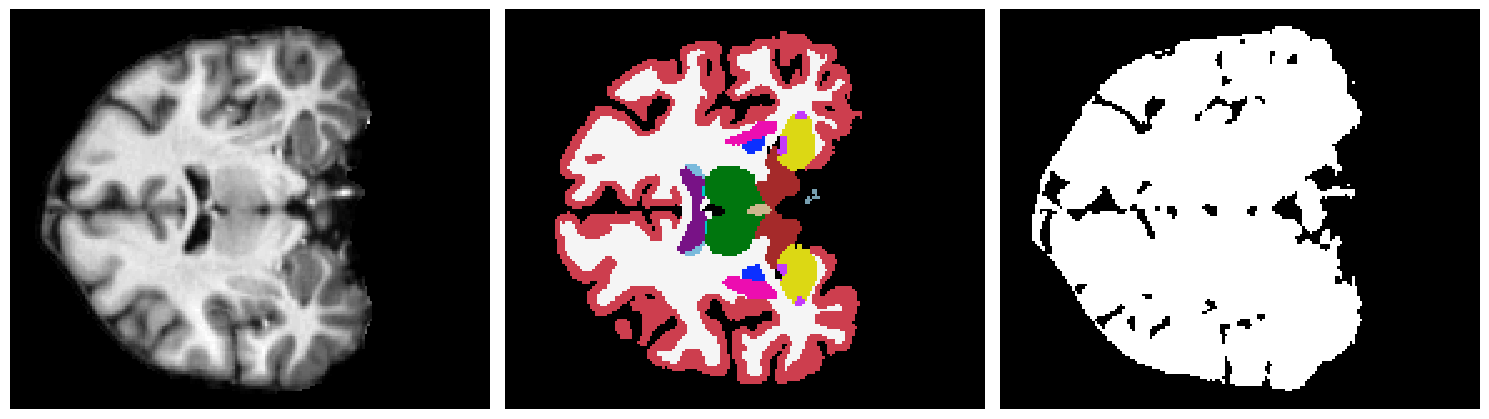

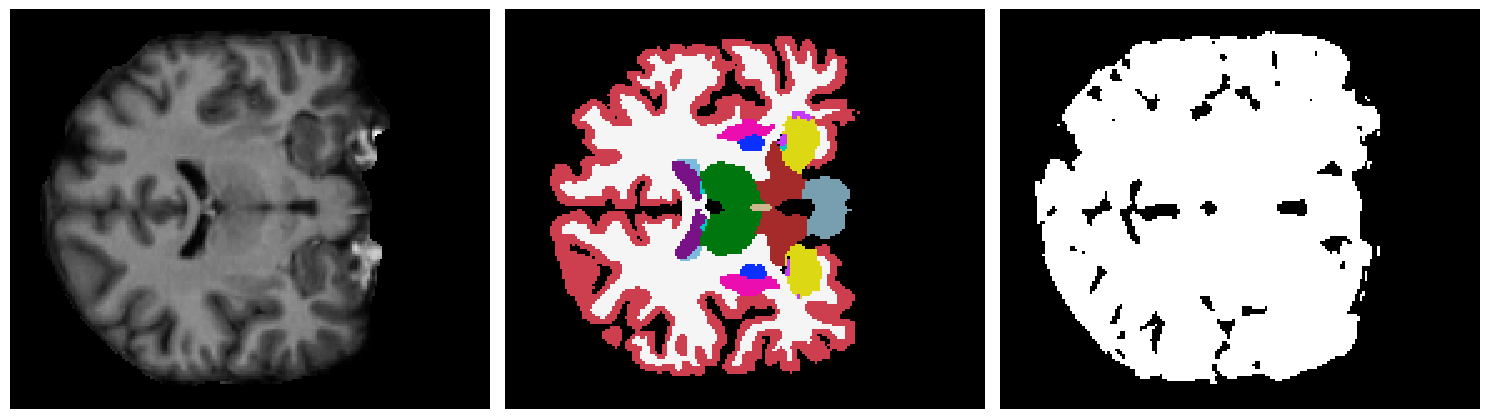

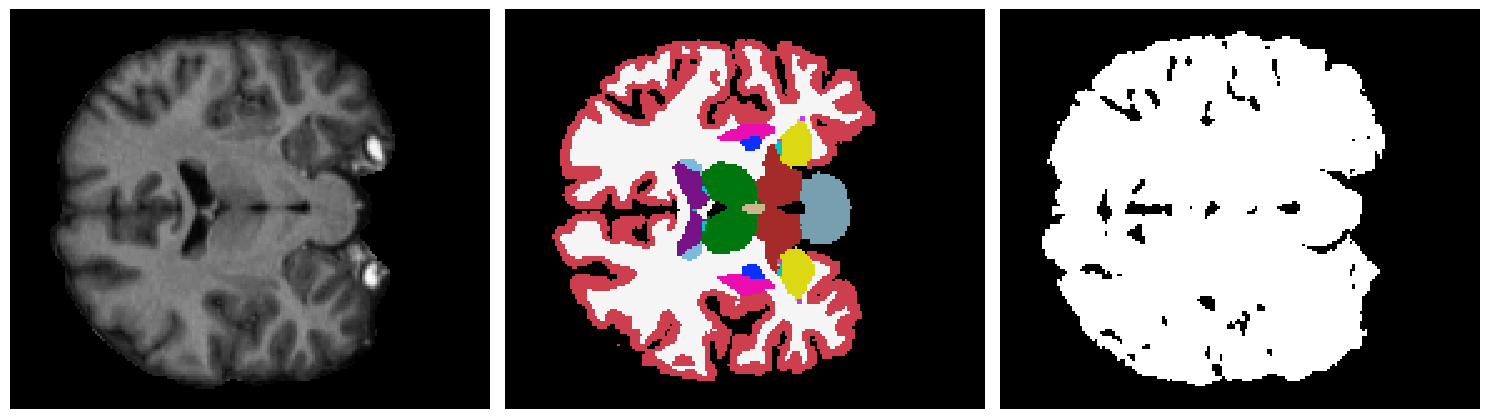

In [15]:
nb_labels=2
nb_features=64
batch_size=8
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3

in_shape = (160,192)

models_directory = 'models.bi.zb.0.2'
model_file='weights_epoch_13950.h5'

gen_arg = {
    'in_shape': in_shape,
    'labels_in': [i for i in range(25)],
    'labels_out': {i: 1 if i > 0 else 0 for i in range(25)},  # This line creates the desired mapping
    'warp_min': 0.01,
    'warp_max': 2,
    'zero_background': 0.2
}



def read_colors_from_csv(filepath):
    colors = []
    with open(filepath, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in spamreader:
            if len(row):
                tokens = row[0].split()
                if tokens[0].isnumeric():
                    colors.append((int(tokens[2])/255.,int(tokens[3])/255.,int(tokens[4])/255.))
    return colors
        
def load_colormap_from_file(filepath):
    colors = read_colors_from_csv(filepath)#, delimiter='     ')
    return colors
custom_cmap1 = mcolors.ListedColormap(load_colormap_from_file('neurite-oasis.2d.v1.0/seg4_labels.txt'))
custom_cmap2 = mcolors.ListedColormap(load_colormap_from_file('neurite-oasis.2d.v1.0/seg24_labels.txt'))
test_gen = my_generator(slice_norm_array_test, batch_size=1, same_subj=False, flip=False)
from tensorflow.keras.models import load_model

unet_model = models.unet(input_shape=(160, 192, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
input_img = Input(shape=(160, 192,1))


gen_model_1 = ne.models.labels_to_image_new(**gen_arg, id=1)
generated_img, y = gen_model_1(input_img)
unet_model = models.unet(input_shape=(160, 192, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)

combined_model.load_weights(os.path.join(models_directory,model_file))
unet_model = models.unet(input_shape=(160, 192, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
unet_model.set_weights(combined_model.get_weights())


dice_coefficients = []  # Create an empty list to store individual Dice coefficients
y_preds=[]
count=0
for i in range(len(slice_norm_array_test)):
    real_img = slice_norm_array_test[i]
    min_value = tf.reduce_min(real_img)
    max_value = tf.reduce_max(real_img)
    real_img = (real_img - min_value) / (max_value - min_value)
    real_img = tf.expand_dims(real_img, axis=0)  # Shape becomes (1, 160, 192, 1)

    y_pred = unet_model.predict(real_img, verbose=0)
    y_true = slice_seg24_array_test[i]  # Ground truth segmentation (integer labels)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    
    y_preds.append(y_pred)
    y_true_binary = tf.where(y_true > 0, 1.0, 0.0)
    y_true = tf.cast(y_true_binary, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    y_true_one_hot = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=nb_labels)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, dtype=tf.int32), depth=nb_labels)
    dice_coefficient_value = dice_coefficient(y_true_one_hot, y_pred_one_hot)
    dice_coefficients.append(dice_coefficient_value)
    

    count = count + 1

average_dice_coefficient = sum(dice_coefficients) / len(dice_coefficients)
print(f"Average Dice Coefficient: {average_dice_coefficient:.4f}")

for i in range(3):
    ne.plot.slices(slices_in=(slice_norm_array_test[i], slice_seg24_array_test[i], y_preds[i]), cmaps=['gray', custom_cmap2, 'gray'])


In [12]:


# models_directory = 'models3'
# model_file='weights_epoch_100.h5'

nb_labels=2
nb_features=64
batch_size=8
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3


# Create a list to store Dice coefficients and model names
dice_coefficients = []
model_names = []
model_epochs = []  # List to store the corresponding epochs


gen_model_1 = ne.models.labels_to_image_new(**gen_arg, id=1)
generated_img, y = gen_model_1(input_img)
unet_model = models.unet(input_shape=(160, 192, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)

# Iterate through the model files in the directory
for filename in os.listdir(models_directory):
    if filename.startswith('weights_epoch_') and filename.endswith('.h5'):
        # Load the model
        # print(filename)
        epoch = int(filename.split('_')[2].split('.')[0])
        # Only load models saved every 50 epochs (adjust the step size as needed)
        if epoch % 500 != 0:
            continue

        combined_model.load_weights(os.path.join(models_directory,filename))
        unet_model = models.unet(input_shape=(160, 192, 1), nb_features=nb_features, nb_labels=nb_labels, nb_levels=nb_levels, conv_size=conv_size)
        unet_model.set_weights(combined_model.get_weights())
        
        dice_values = []
        for i in range(len(slice_seg24_array_test)):
            real_img = slice_norm_array_test[i]
            min_value = tf.reduce_min(real_img)
            max_value = tf.reduce_max(real_img)
            # real_img = (real_img - min_value) / (max_value - min_value)
            real_img = tf.expand_dims(real_img, axis=0)

            y_pred = unet_model.predict(real_img, verbose=0)
            # print(np.sum(real_img),np.sum(y_pred))
            y_true = slice_seg24_array_test[i]
            y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
            y_true = tf.squeeze(y_true, axis=-1)
            y_true_binary = tf.where(y_true > 0, 1.0, 0.0)

            y_true = tf.cast(y_true_binary, dtype=tf.float32)
            y_pred = tf.cast(y_pred, dtype=tf.float32)

            y_true_one_hot = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=nb_labels)
            y_pred_one_hot = tf.one_hot(tf.cast(y_pred, dtype=tf.int32), depth=nb_labels)
            dice_coefficient_value = dice_coefficient(y_true_one_hot, y_pred_one_hot)
            dice_values.append(dice_coefficient_value)

        # Calculate the average Dice coefficient for the model
        average_dice_coefficient = np.mean(dice_values)
        dice_coefficients.append(average_dice_coefficient)
        model_names.append(filename)
        model_epochs.append(epoch)

sorted_models = [x for _, x in sorted(zip(model_epochs, dice_coefficients))]
sorted_epochs = sorted(model_epochs)
sorted_coefficients = sorted(dice_coefficients)

# Plot a curve to show the changes for every 5000 epochs
# Use the sorted epochs as x-axis values
plt.plot(sorted_epochs, sorted_coefficients, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Average Dice Coefficient')
plt.title('Average Dice Coefficient vs. Epochs (Every 200 Epochs)')
plt.grid()
plt.tight_layout()

# Save the curve as an image
plt.savefig('dice_coefficient_curve.png')

# Show the curve
plt.show()

using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
using final_pred_activation softmax for unet


KeyboardInterrupt: 